In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import re
from torchvision import datasets, models, transforms
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch 
from torchvision import datasets, models, transforms

from utils import *

import unicodedata
import string
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
print(n_categories)
all_categories

18


['French',
 'Portuguese',
 'Scottish',
 'Italian',
 'Czech',
 'Greek',
 'English',
 'Spanish',
 'Chinese',
 'Korean',
 'German',
 'Irish',
 'Vietnamese',
 'Polish',
 'Japanese',
 'Russian',
 'Dutch',
 'Arabic']

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
categoryFromOutput(output)

('Irish', 11)

In [8]:
class Name_Dataset(Dataset):
    
    def __init__(self,root = 'data/train2.csv' ,  transform=None):
        self.df = pd.read_csv(root)
        self.root = root
        self.transform = transform
        self.all_categories = np.unique(self.df["Class"].values)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, classe = self.df.iloc[idx]["Name"], self.df.iloc[idx]["Class"]
        category_tensor = torch.tensor([list(all_categories).index(classe)], dtype=torch.long)

        if(self.transform):
            name = self.transform(name)
        return name, category_tensor

In [9]:
D = Name_Dataset(transform = lineToTensor)
D[0]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0.,

In [10]:
learning_rate = 0.005 
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 10000
plot_every = 10000
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 10% (0m 12s) 1.3846 Dao / Chinese ✗ (Vietnamese)
20000 20% (0m 25s) 1.2189 Vinh / Vietnamese ✓
30000 30% (0m 37s) 1.4121 Ibarra / Portuguese ✗ (Spanish)
40000 40% (0m 49s) 0.3143 Arnoni / Italian ✓
50000 50% (1m 2s) 3.2923 Kennedy / English ✗ (Scottish)
60000 60% (1m 15s) 0.2313 Kanavos / Greek ✓
70000 70% (1m 29s) 0.8284 Adamidis / Greek ✓
80000 80% (1m 42s) 0.6854 Conall / Irish ✓
90000 90% (1m 55s) 1.7150 Ghannam / Arabic ✓
100000 100% (2m 7s) 0.4476 Luc / Vietnamese ✓


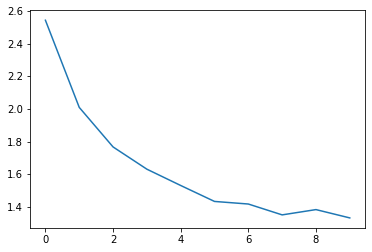

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


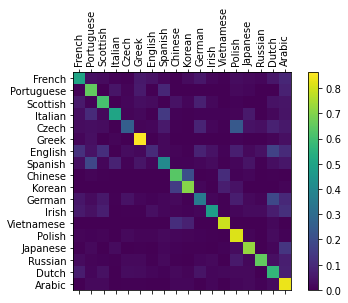

In [16]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()